In [63]:
#import
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from osgeo import ogr, osr
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
import shapely.wkt
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.10'

The example is from here: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb

## Functions

In [64]:
# get one color for each isochrone
iso_colours = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

#info for later on
network_type = 'walk'
trip_times = [5, 10] #in minutes
travel_speed = 4.8 #walking speed in km/hour
metres_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute

# isochrone function
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, centre_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

## from place name

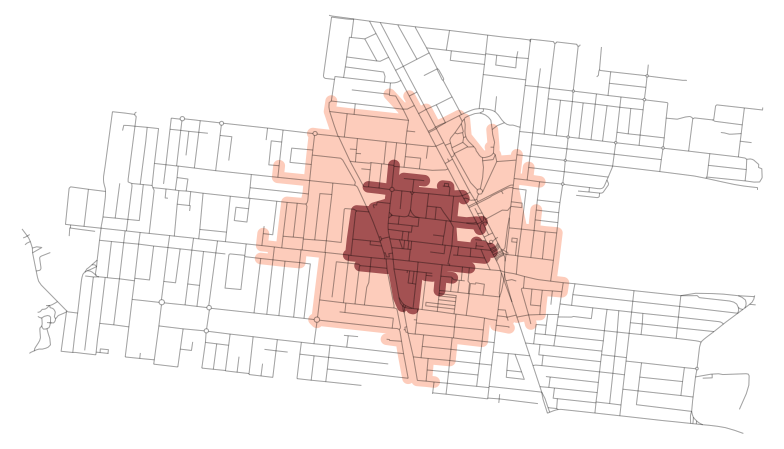

In [65]:
# configure the place, network type, trip times, and travel speed
place = 'Moonee Ponds, Victoria, Australia'
network_type = 'walk'
trip_times = [5, 10] #in minutes
travel_speed = 4.8 #walking speed in km/hour


# download the street network
G = ox.graph_from_place(place, network_type=network_type)

# find the centremost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
centre_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

# add an edge attribute for time in minutes required to traverse each edge
metres_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / metres_per_minute

# make the polygons    
isochrone_polys_place = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys_place, iso_colours):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

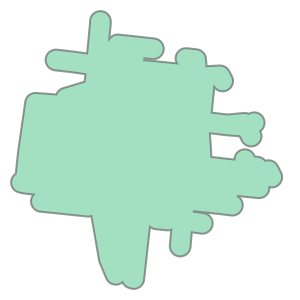

In [66]:
# 400m - 5 minutes
isochrone_polys_place[1]

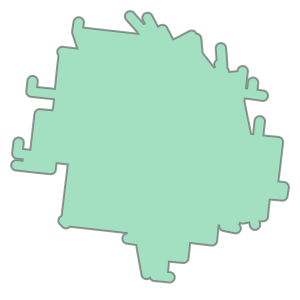

In [67]:
# 800m - 10 minutes
isochrone_polys_place[0]

## export
shapely doesn't have a crs. need to convert the wkt then make the object

In [68]:
#the wkt for the 400m
P = shapely.wkt.loads(isochrone_polys_place[1].wkt)

# Now convert it to a shapefile with OGR    
sr = osr.SpatialReference()
# or sr.ImportFromProj4(edges.crs)
sr.ImportFromProj4('+proj=utm +zone=55 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.CreateDataSource('shp\moonee_ponds_400m_v2.shp')
layer = ds.CreateLayer('route', sr, ogr.wkbPolygon)# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

## If there are multiple geometries, put the "for" loop here

# Create a new feature (attribute and geometry)
feat = ogr.Feature(defn)
feat.SetField('id', 123)

# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(P.wkb)
feat.SetGeometry(geom)
layer.CreateFeature(feat)
feat =  None 

# Save and close the data source
ds = None

## From centoids

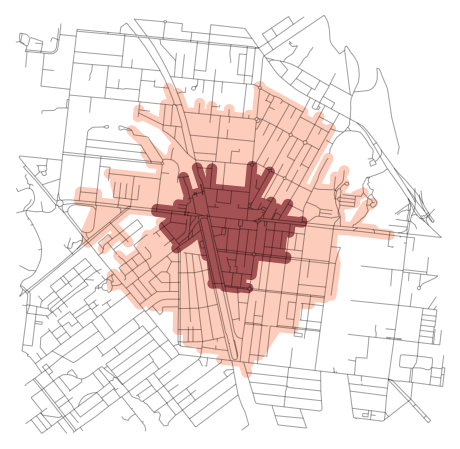

In [141]:
# configure the place, network type, trip times, and travel speed
coords = (-37.788513, 144.930533) #Flemington library
network_type = 'walk'
trip_times = [5, 10] #in minutes
travel_speed = 4.8 #walking speed in km/hour

# download the street network
G = ox.graph_from_point(coords, network_type=network_type)

# run from the centroid
centre_node = ox.get_nearest_node(G, (coords[0], coords[1]))
G = ox.project_graph(G)

# add an edge attribute for time in minutes required to traverse each edge
metres_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / metres_per_minute
    
# make the polygons    
isochrone_polys_cent = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys_cent, iso_colours):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

### test of iteration

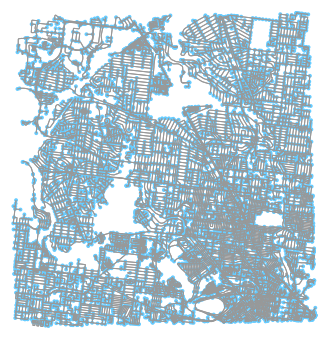

(<Figure size 405.698x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x252ef40f898>)

In [70]:
# the area 
mv = ox.graph_from_bbox(-37.705, -37.796, 144.949, 144.84, network_type='walk')
mv_projected = ox.project_graph(mv)
ox.plot_graph(mv_projected)

In [142]:
multiple_coords = ((-37.773981, 144.915669), 
                   (-37.765443, 144.863070), 
                   (-37.736089, 144.888972), 
                   (-37.764914, 144.924148), 
                   (-37.788513, 144.930533)) 
#libraries

In [143]:
for i in multiple_coords:
    print(i)

(-37.773981, 144.915669)
(-37.765443, 144.86307)
(-37.736089, 144.888972)
(-37.764914, 144.924148)
(-37.788513, 144.930533)


In [183]:
# test function to do multiple ones 
def iterate_multiple_coords(the_coordinates):
    for i in the_coordinates:
        centre_node = ox.get_nearest_node(mv, (i[0], i[1]))
        print("starting" + str(i)) # to check
        # add an edge attribute for time in minutes required to traverse each edge
        for u, v, k, data in mv_projected.edges(data=True, keys=True):
            data['time'] = data['length'] / metres_per_minute
        # make the polygons    
        isochrone_polys_iter = make_iso_polys(mv_projected, edge_buff=25, node_buff=0, infill=True)
        print("done " + str([i])) # to check
        poly_list.append(isochrone_polys_iter)
        print("appended " + str([i])) # to check
    return(poly_list)

In [184]:
#list of shapely objects
test = iterate_multiple_coords(multiple_coords)

starting(-37.773981, 144.915669)
done [(-37.773981, 144.915669)]
appended [(-37.773981, 144.915669)]
done [(-37.773981, 144.915669)]
appended [(-37.773981, 144.915669)]
done [(-37.773981, 144.915669)]
appended [(-37.773981, 144.915669)]
done [(-37.773981, 144.915669)]
appended [(-37.773981, 144.915669)]
done [(-37.773981, 144.915669)]
appended [(-37.773981, 144.915669)]
done [(-37.773981, 144.915669)]
appended [(-37.773981, 144.915669)]
done [(-37.773981, 144.915669)]
appended [(-37.773981, 144.915669)]
done [(-37.773981, 144.915669)]
appended [(-37.773981, 144.915669)]


KeyboardInterrupt: 

to do:
* work out how to get the multiple list objects to wkt
* get back in to shp
* dissolve (or something like that in fewer steps)
* perhaps add name input or output it to a temporary file

In [167]:
for i in test:
    print(i)
    print(i[0].area)
    print(i[1].area)

[<shapely.geometry.polygon.Polygon object at 0x00000252EED81048>, <shapely.geometry.polygon.Polygon object at 0x0000025299DCD7B8>]
1221891.0262004482
278954.2285476034
[<shapely.geometry.polygon.Polygon object at 0x00000252F24B8470>, <shapely.geometry.polygon.Polygon object at 0x00000252F1269470>]
1221891.0262004482
278954.2285476034
[<shapely.geometry.polygon.Polygon object at 0x00000252872C0080>, <shapely.geometry.polygon.Polygon object at 0x00000252E838DF98>]
1221891.0262004482
278954.2285476034
[<shapely.geometry.polygon.Polygon object at 0x00000252F11805F8>, <shapely.geometry.polygon.Polygon object at 0x00000252F0DBA3C8>]
1170723.0839951886
254020.00263692273
[<shapely.geometry.polygon.Polygon object at 0x00000252EE7ECD68>, <shapely.geometry.polygon.Polygon object at 0x00000252F0EE0748>]
1170723.0839951886
254020.00263692273
[<shapely.geometry.polygon.Polygon object at 0x0000025284B90F60>, <shapely.geometry.polygon.Polygon object at 0x000002529994D048>]
1170723.0839951886
254020.0

In [172]:
#convert the polygons to lists of wkt
list_400m = []
list_800m = []

for i in test:
    list_400m.append(i[0].wkt)
    list_800m.append(i[1].wkt)

In [173]:
list_400m

['POLYGON ((317563.0127930298 -4184953.733303222, 317562.4149842589 -4184956.017916444, 317561.5642732187 -4184958.319086231, 317560.4921045029 -4184960.525790992, 317559.2088036821 -4184962.616778956, 317557.726729645 -4184964.571912764, 317556.0601555745 -4184966.37236341, 317554.2251314902 -4184968.000791569, 317552.239329677 -4184969.441514588, 317550.1218744919 -4184970.680657518, 317547.8931581859 -4184971.706286733, 317545.5746445155 -4184972.508524864, 317543.1886620345 -4184973.07964592, 317540.7581890586 -4184973.414149692, 317538.3066323713 -4184973.508814726, 317535.8576018036 -4184973.362729346, 317533.4346828586 -4184972.977300435, 317531.0612095703 -4184972.356239883, 317528.7600397839 -4184971.505528843, 317526.5533350224 -4184970.433360127, 317524.462347059 -4184969.150059306, 317522.5072132507 -4184967.667985269, 317520.7067626051 -4184966.001411199, 317519.0783344458 -4184964.166387114, 317517.6376114265 -4184962.180585301, 317516.3984684973 -4184960.063130116, 31751

In [174]:
print(len(list_400m))

22


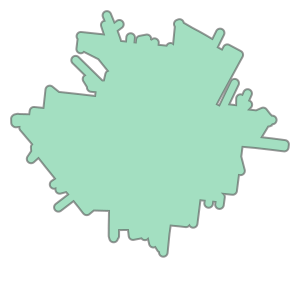

In [175]:
test[0][0]

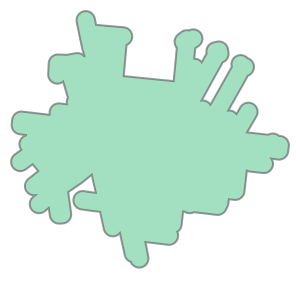

In [176]:
test[0][1]

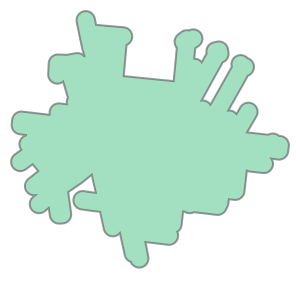

In [177]:
test[1][1]

In [178]:
multi_poly = MultiPolygon(map(shapely.wkt.loads, list_400m))
print(multi_poly)

MULTIPOLYGON (((317563.0127930298 -4184953.733303222, 317562.4149842589 -4184956.017916444, 317561.5642732187 -4184958.319086231, 317560.4921045029 -4184960.525790992, 317559.2088036821 -4184962.616778956, 317557.726729645 -4184964.571912764, 317556.0601555745 -4184966.37236341, 317554.2251314902 -4184968.000791569, 317552.239329677 -4184969.441514588, 317550.1218744919 -4184970.680657518, 317547.8931581859 -4184971.706286733, 317545.5746445155 -4184972.508524864, 317543.1886620345 -4184973.07964592, 317540.7581890586 -4184973.414149692, 317538.3066323713 -4184973.508814726, 317535.8576018036 -4184973.362729346, 317533.4346828586 -4184972.977300435, 317531.0612095703 -4184972.356239883, 317528.7600397839 -4184971.505528843, 317526.5533350224 -4184970.433360127, 317524.462347059 -4184969.150059306, 317522.5072132507 -4184967.667985269, 317520.7067626051 -4184966.001411199, 317519.0783344458 -4184964.166387114, 317517.6376114265 -4184962.180585301, 317516.3984684973 -4184960.063130116, 3